In [146]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

def generate_synth_dataset(p: float, n: int, d: int, g: float)->pd.DataFrame:
    """Generating a synthetic dataset
    Args:
        p (float): class prior probability
        n (int): number of observations
        d (int): number of features (dimensions)
        g (float): correlation between features
    Returns:
        Datadrame: dataset with d features, n rows
    """
    Y = np.random.binomial(1, p, size=n)
    S = np.array([[g ** abs(i - j) for j in range(d)] for i in range(d)])
    
    mean_0 = np.zeros(d)
    mean_1 = np.array([1/(i+1) for i in range(d)])
    
    X = np.array([
        multivariate_normal.rvs(mean=mean_1 if y == 1 else mean_0, cov=S)
        for y in Y
    ])
    
    feature_names = [f'f{i+1}' for i in range(d)]
    dataset = pd.DataFrame(X, columns=feature_names)
    dataset['Y'] = Y
    
    return dataset


In [147]:
from sklearn.linear_model import LogisticRegression

ban = LogisticRegression()

In [148]:
p = 0.5   # probability of class = 1
n = 200   # number of observations
d = 10    # number of features
g = 0.5   # correlation between features

dataset = generate_synth_dataset(p, n, d, g)
print(dataset.head())

         f1        f2        f3        f4        f5        f6        f7  \
0 -0.154507  0.716470  0.754829 -0.131233 -0.418048  0.942866  1.178066   
1 -1.842273 -2.332878 -0.708548 -0.566468 -0.293041 -1.159277 -2.041177   
2  1.549385  0.467640  0.812048 -0.214845  0.681464  1.206222  0.945101   
3  0.516003 -0.072799 -0.008899  0.896568  1.061623 -1.257016  0.173109   
4  0.921968 -0.691531 -0.565948 -0.511112  0.733947  0.758283  0.501132   

         f8        f9       f10  Y  
0  1.116352  0.147638 -0.647709  0  
1 -1.732521 -0.697982  1.203347  0  
2 -0.420629  0.116206  0.281166  1  
3 -0.374100 -0.582775 -1.864552  1  
4  0.256584 -0.880662 -1.944437  0  


In [149]:
from sklearn.model_selection import train_test_split

feature_cols =['f1','f2','f3','f4','f5','f6','f7','f8', 'f9','f10']
y = dataset.Y
X = dataset[feature_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


In [150]:
β = np.zeros(X_train.shape[1])
xi = X_train.iloc[0].values
print(xi)
print(β)
np.dot(xi, β)


[-0.94084307 -0.22726815 -0.82518003 -0.43927462  0.12483012  1.27438112
  1.05554546  0.10526005  0.63382759 -0.88241049]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


np.float64(0.0)

In [151]:
np.array(y_train)

array([1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0])

In [152]:
from sklearn.metrics import roc_auc_score, average_precision_score, recall_score, precision_score, f1_score, balanced_accuracy_score

class LogRegCCD:
    def __init__(self, lambdas):
        self.lambdas = lambdas
        self.coef_path_ = []
        self.intercept_path_ = []
        self.best_lambda_ = None
        self.best_coef_ = None
        self.best_intercept_ = None

    def fit(self, X_train, y_train, alpha=1.0, tol=1e-8, max_iter=100):
        """Train logistic regression with CCD"""
        X = np.array(X_train)
        y = np.array(y_train)
        N, d = X.shape
        
        for l in self.lambdas:  # Iterate through each lambda
            b = np.zeros(d)  # Initialize weights to zero
            b_0 = 0  # Initialize bias (intercept)
            
            for iteration in range(max_iter):
                b_old = b.copy()
                b0_old = b_0
                
                # Compute probability predictions
                linear_comb = b_0 + X @ b
                p = 1 / (1 + np.exp(-linear_comb))  # Sigmoid function
                # w = p * (1 - p)                
                # Update each coordinate j independently
                for j in range(d):
                    X_j = X[:, j]  # Extract feature column
                    # numerator = np.sum(w * X_j * (y - p)) # ∑ w_i x_ij (y_i - p_i)
                    # denominator = np.sum(w * X_j**2) + l * (1 - alpha) 
                    numerator = np.sum(X_j * (y - p))  # ∑ x_ij (y_i - p_i)
                    denominator = np.sum(X_j**2)  # ∑ x_ij^2
                    denominator = max(denominator, 1e-10)  # Prevent division by zero
                    b[j] = self.soft_threshold(numerator / denominator, l * alpha)

                b_0 = np.mean(y - p)
                
                if np.max(np.abs(b - b_old)) < tol and np.abs(b_0 - b0_old) < tol:
                    break

            # Store the solution path
            self.coef_path_.append(b.copy())
            self.intercept_path_.append(b_0)

    def validate(self, X_valid, y_valid, measure='roc_auc'):
        best_score = -np.inf
        best_lambda = None
        best_index = None

        for i, l in enumerate(self.lambdas):
          b = self.coef_path_[i]
          b_0 = self.intercept_path_[i]
          probas = 1 / (1 + np.exp(-(b_0 + X_valid @ b)))
          if measure in ['recall', 'precision', 'f_measure', 'balanced_accuracy']:
            predictions = (probas >= 0.5).astype(int)
            score = self.compute_measure(y_valid, predictions, measure)
          elif measure == 'roc_auc':
            score = roc_auc_score(y_valid, probas)
          elif measure == 'sensitivity_precision_auc':
              score = average_precision_score(y_valid, probas)

          if score > best_score:
              best_score = score
              best_lambda = l
              best_index = i
        self.best_lambda_ = best_lambda
        self.best_coef_ = self.coef_path_[best_index]
        self.best_intercept_ = self.intercept_path_[best_index]

    def predict_proba(self, X_test):
        return 1 / (1 + np.exp(-(self.best_intercept_ + X_test @ self.best_coef_)))

    def plot(self, X_valid, y_valid, measure='roc_auc'):
        """Plot performance measure vs lambda"""
        scores = []

        for i, l in enumerate(self.lambdas):
            b = self.coef_path_[i]
            b_0 = self.intercept_path_[i]
            probas = 1 / (1 + np.exp(-(b_0 + X_valid @ b)))

            if measure in ['recall', 'precision', 'f_measure', 'balanced_accuracy']:
                predictions = (probas >= 0.5).astype(int)
                score = self.compute_measure(y_valid, predictions, measure)
            elif measure == 'roc_auc':
                score = roc_auc_score(y_valid, probas)
            elif measure == 'sensitivity_precision_auc':
                score = average_precision_score(y_valid, probas)

            scores.append(score)

        plt.figure(figsize=(8, 5))
        plt.plot(self.lambdas, scores, marker='o', linestyle='-')
        plt.xscale("log")
        plt.xlabel("Lambda")
        plt.ylabel(measure)
        plt.title(f"Performance Measure ({measure}) vs Lambda")
        plt.grid(True)
        plt.show()

    def plot_coefficients(self):
        """Plot coefficient paths vs lambda"""
        coef_paths = np.array(self.coef_path_).T

        plt.figure(figsize=(10, 6))
        for coef in coef_paths:
            plt.plot(self.lambdas, coef, linestyle='-', marker='.')
        plt.xscale("log")
        plt.xlabel("Lambda")
        plt.ylabel("Coefficient Value")
        plt.title("Coefficient Paths vs Lambda")
        plt.grid(True)
        plt.show()    

    def soft_threshold(self, z, gamma):
        if z > gamma:
            return z - gamma
        elif z < -gamma:
            return z + gamma
        else:
            return 0

    def compute_measure(self, y_true, y_pred, measure):
      if measure == "recall":
          return recall_score(y_true, y_pred)
      elif measure == "precision":
          return precision_score(y_true, y_pred)
      elif measure == "f_measure":
          return f1_score(y_true, y_pred)
      elif measure == "balanced_accuracy":
          return balanced_accuracy_score(y_true, y_pred)
      else:
          raise ValueError(f"Unknown measure: {measure}")

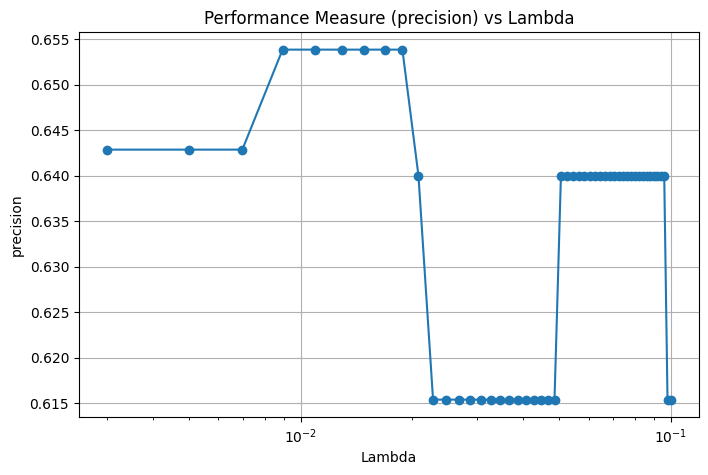

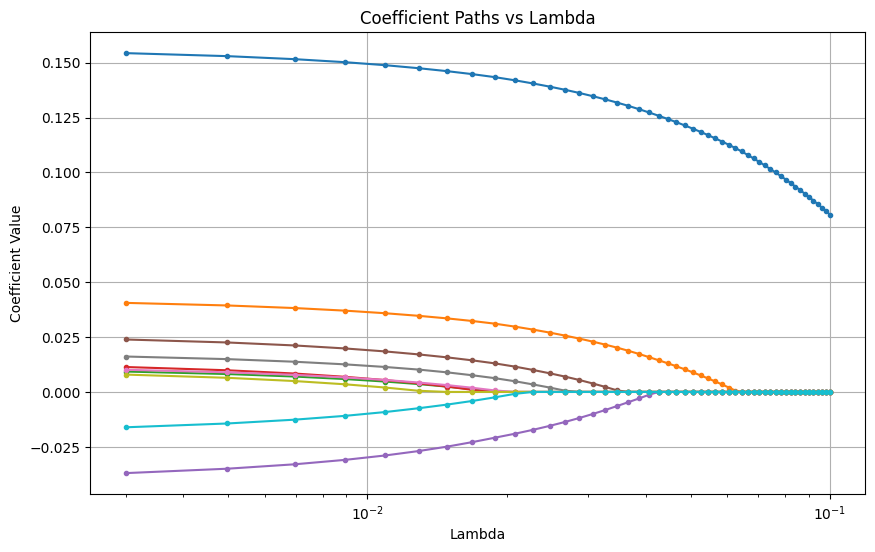

In [154]:
lambdas = np.linspace(0.1, 0.003, 50)  # explicitly 100 lambda values from 0.001 to 0.000001
model = LogRegCCD(lambdas=lambdas)
model.fit(X_train, y_train)
model.validate(X_val, y_val)
# print(model.intercept_path_)
# Validate and select best lambda
model.plot(X_val, y_val, measure="precision")
model.plot_coefficients()